# What's this about

### In this notebook we do a worked example of constructing and fitting a model to data in tf, pytorch and jax, including the basic set of "things" that you need to be able to do in any given framework to get started building and training models.

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

# Neural network regression

### Training data

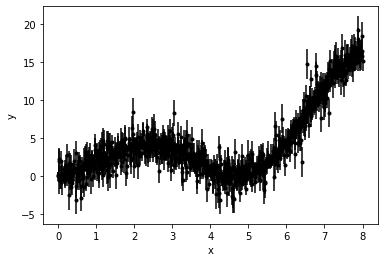

In [8]:
N = 1000 # number of training data
x = np.linspace(0, 8, N).astype(np.float32) # x-values
std = np.random.uniform(0.1, 2, N).astype(np.float32) # noise std-deviations of the measurements
y = x*np.sin(x) + x + np.random.normal(0, std).astype(np.float32) # noisy y-values

# plot the training data
plt.errorbar(x, y, yerr=std, fmt='.k')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Tensorflow solution

Keras model

100%|██████████| 1000/1000 [00:36<00:00, 27.36it/s, training_loss=1.87, validation_loss=1.45] 


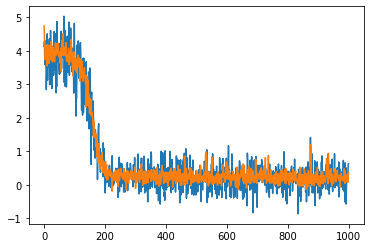

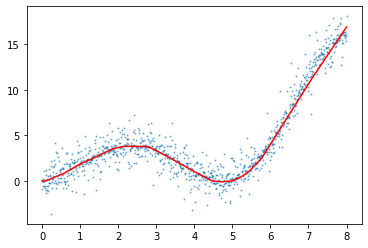

In [4]:
# make a network model
Model = tf.keras.Sequential([tf.keras.layers.Dense(64, input_shape=(1,), activation=tf.nn.leaky_relu), # hidden layer
                             tf.keras.layers.Dense(64, activation=tf.nn.leaky_relu),
                             tf.keras.layers.Dense(1, activation=tf.nn.leaky_relu)]) # output layer (one output here)

# optimizer
optimizer = tf.keras.optimizers.Adam(lr=1e-3)

# training parameters
epochs = 1000
batch_size = 128
validation_split = 0.2
n_validation = int(N * validation_split)
n_training = N - n_validation

# holders for training and validation losses
training_loss = [np.inf]
validation_loss = [np.inf]

# main training loop over epochs (with progress bar)
with trange(epochs) as progress:
    for epoch in progress:
        
        # make and shuffle the dataset for iterating over
        dataset = tf.data.Dataset.from_tensor_slices((x[...,np.newaxis], y[...,np.newaxis], std[...,np.newaxis])).shuffle(N) # training data should have shapes (..., n_dims), where n_dims here is 1 everywhere

        # split dataset into training and validation samples
        training_data = dataset.take(n_training).batch(batch_size) # take the first n_training members and batch them up
        validation_data = dataset.skip(n_training).batch(n_validation) # skip the first n_training members, and make a single batch of size n_validation for the validation set
        
        # loop over training batches for this epoch
        for x_, y_, std_ in training_data:
            
            # compute the loss and gradients using gradient tape
            with tf.GradientTape() as tape:

                # which variables do you want to keep track of gradients for?
                tape.watch(Model.trainable_variables)

                # compute the loss
                loss = tf.reduce_mean((y_ - Model(x_))**2 / std_**2)
                
            # compute the gradients wrt the trainable variables
            gradients = tape.gradient(loss, Model.trainable_variables)
            
            # apply gradients to optimizer
            optimizer.apply_gradients(zip(gradients, Model.trainable_variables))
            
            # update the progressbar
            progress.set_postfix({'training_loss':loss.numpy(), 'validation_loss':validation_loss[-1]})
            
        # save the training loss as the end of the epoch
        training_loss.append(loss.numpy())
        
        # compute validation loss at the end of the epoch
        for x_, y_, std_ in validation_data:
            loss = tf.reduce_mean((y_ - Model(x_))**2 / std_**2)
        validation_loss.append(loss.numpy())
        
        # update the progressbar
        progress.set_postfix({'training_loss':training_loss[-1], 'validation_loss':validation_loss[-1]})
        
# plot the training curve and predictions
plt.plot(np.log(training_loss[1:]))
plt.plot(np.log(validation_loss[1:]))
plt.show()

# plot the predictions
plt.close()
plt.scatter(x, y, s = 1, alpha=0.5)
plt.plot(x, Model(x[...,np.newaxis]).numpy()[:,0], color = 'red')
plt.show()

Custom tf.Module model (with full control)

In [ ]:
# create model as a tf.Module. Note this must have a __call__ function, implementing the basic model call, and it will automatically collect all trainable variables together into a trainable_variables attribute
class RegressionModel(tf.Module):
    
    def __init__(self, n_inputs=1, n_outputs=1, n_hidden=[64, 64], activation=[tf.nn.leaky_relu, tf.nn.leaky_relu, tf.nn.leaky_relu], std_init=1e-3):
        
        # architecture
        self.architecture = [n_inputs] + n_hidden + [n_outputs]
        self.n_layers = len(self.architecture) - 1
        self.activation = activation
        
        # create trainable weights and biases
        self.W = []
        self.b = []
        for i in range(self.n_layers):
            self.W.append(tf.Variable(tf.random.normal([self.architecture[i], self.architecture[i+1]], 0., std_init), name="W_" + str(i), trainable=True))
            self.b.append(tf.Variable(tf.random.normal([self.architecture[i+1]], 0., std_init), name = "b_" + str(i), trainable=True))
            
    # model call
    def __call__(self, inputs):
        
        # implement dense network by hand here
        outputs = inputs
        for i in range(self.n_layers):
            
            outputs = self.activation[i](tf.matmul(outputs, self.W[i]) + self.b[i])
            
        return outputs
    

100%|██████████| 2000/2000 [00:59<00:00, 33.54it/s, training_loss=0.777, validation_loss=1.19] 


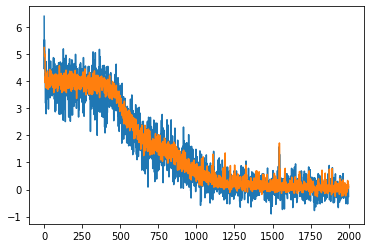

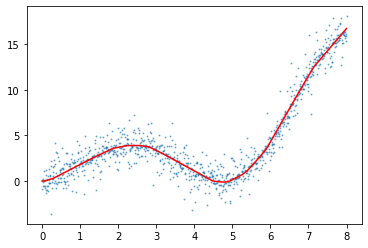

In [6]:
# create model instance
Model = RegressionModel()
    
# optimizer
optimizer = tf.keras.optimizers.Adam(lr=1e-3)

# training parameters
epochs = 2000
batch_size = 128
validation_split = 0.2
n_validation = int(N * validation_split)
n_training = N - n_validation

# holders for training and validation losses
training_loss = [np.inf]
validation_loss = [np.inf]

# main training loop over epochs (with progress bar)
with trange(epochs) as progress:
    for epoch in progress:
        
        # make and shuffle the dataset for iterating over
        dataset = tf.data.Dataset.from_tensor_slices((x[...,np.newaxis], y[...,np.newaxis], std[...,np.newaxis])).shuffle(N) # training data should have shapes (..., n_dims), where n_dims here is 1 everywhere

        # split dataset into training and validation samples
        training_data = dataset.take(n_training).batch(batch_size) # take the first n_training members and batch them up
        validation_data = dataset.skip(n_training).batch(n_validation) # skip the first n_training members, and make a single batch of size n_validation for the validation set
        
        # loop over training batches for this epoch
        for x_, y_, std_ in training_data:
            
            # compute the loss and gradients using gradient tape
            with tf.GradientTape() as tape:

                # which variables do you want to keep track of gradients for?
                tape.watch(Model.trainable_variables)

                # compute the loss
                loss = tf.reduce_mean((y_ - Model(x_))**2 / std_**2)
                
            # compute the gradients wrt the trainable variables
            gradients = tape.gradient(loss, Model.trainable_variables)
            
            # apply gradients to optimizer
            optimizer.apply_gradients(zip(gradients, Model.trainable_variables))
            
            # update the progressbar
            progress.set_postfix({'training_loss':loss.numpy(), 'validation_loss':validation_loss[-1]})
            
        # save the training loss as the end of the epoch
        training_loss.append(loss.numpy())
        
        # compute validation loss at the end of the epoch
        for x_, y_, std_ in validation_data:
            loss = tf.reduce_mean((y_ - Model(x_))**2 / std_**2)
        validation_loss.append(loss.numpy())
        
        # update the progressbar
        progress.set_postfix({'training_loss':training_loss[-1], 'validation_loss':validation_loss[-1]})
        
# plot the training curve and predictions
plt.plot(np.log(training_loss[1:]))
plt.plot(np.log(validation_loss[1:]))
plt.show()

# plot the predictions
plt.close()
plt.scatter(x, y, s = 1, alpha=0.5)
plt.plot(x, Model(x[...,np.newaxis]).numpy()[:,0], color = 'red')
plt.show()